## Redefine vertical level depths

Move vertical levels to avoid awkward jump in resolution near shelf break depth and weird bumps when calculating derivatives.

In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns

In [3]:
# Datasets
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run01/gridGlob.nc' 
GridOut = Dataset(Grid)

# Vertical spacings
drC = GridOut.variables['drC'][:] # Zp1, r cell center separation (91)
drF = GridOut.variables['drF'][:] # Z, r cell face separation (90)

# R coordinates
RC = GridOut.variables['RC'][:] # (Z) R coordinate of cell center (90)
RF = GridOut.variables['RF'][:] # (Zp1) R coordinate of cell interface (91)
RL = GridOut.variables['RL'][:] # (Zl) R coordinate of lower interface (90)
RU = GridOut.variables['RU'][:] # (Z?) R coordinate of upper interface (90)

# Vertical Coordinates
Zp1 = GridOut.variables['Zp1'][:] # vertical coordinate of cell interface
Z = GridOut.variables['Z'][:] # vertical coordinate of cell center
Zl = GridOut.variables['Zl'][:] # vertical coordinate of upper cell interface

### Original vertical grids look like this:

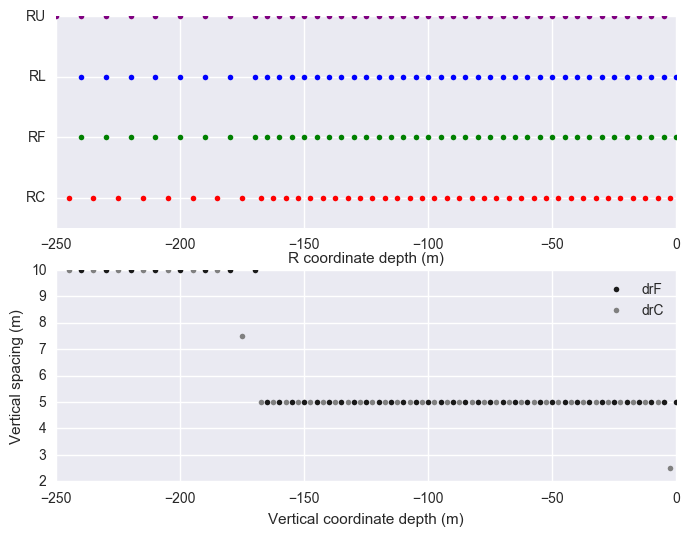

In [4]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8,6))

ax1.plot(RC[:42],np.ones(len(RC[:42])),'ro',markersize=4)
ax1.plot(RF[:42],1.1*np.ones(len(RF[:42])),'go',markersize=4)
ax1.plot(RL[:42],1.2*np.ones(len(RL[:42])),'bo',markersize=4)
ax1.plot(RU[:42],1.3*np.ones(len(RU[:42])),'o',color='purple',markersize=4)
ax1.set_xlabel('R coordinate depth (m)',labelpad = 0)
ax1.set_yticks([1.0,1.1,1.2,1.3])
ax1.set_yticklabels(['RC','RF','RL','RU'])

ax2.plot(Zp1[:42],drF[:42],'o',color='0.1',markersize=4,label='drF')
ax2.plot(Z[:42],drC[:42],'o',color='0.5',markersize=4,label='drC')
ax2.set_xlabel('Vertical coordinate depth (m)')
ax2.set_ylabel('Vertical spacing (m)')
ax2.legend(loc=0)

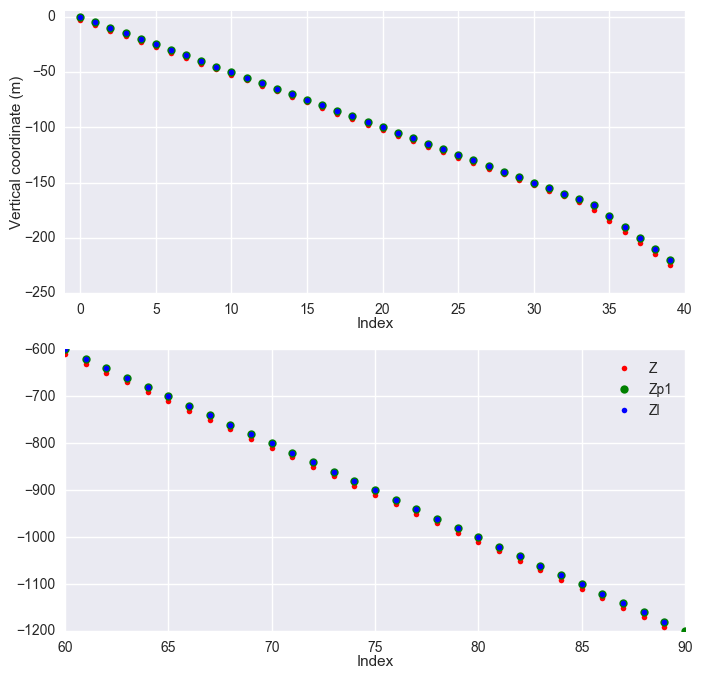

In [5]:
fig,(ax3,ax4) = plt.subplots(2,1, figsize=(8,8))

ax3.plot(Z[:40],'ro',markersize=4,label='Z')
ax3.plot(Zp1[:40],'go',markersize=6,label='Zp1')
ax3.plot(Zl[:40],'bo',markersize=4,label='Zl')
ax3.set_ylabel('Vertical coordinate (m)',labelpad = 0)
ax3.set_xlabel('Index',labelpad = 0)
ax3.set_xlim(-1,40)
ax3.set_ylim(-250,5)
ax4.plot(range(60,90),Z[60:],'ro',markersize=4,label='Z')
ax4.plot(range(60,91),Zp1[60:],'go',markersize=6,label='Zp1')
ax4.plot(range(60,90),Zl[60:],'bo',markersize=4,label='Zl')
ax4.set_xlabel('Index',labelpad = 0)
ax4.legend(loc=0)

|R coordinates|Description|Vertical coordinate|Size|Starts at (m)| Ends at (m)|
|:------------:|:---------:|:-----------------:|:------:|:---------:|:---------:|
|RC|of cell center|Z|90| -2.5 | -1190.0 |
|RF|of cell interface|Zp1|91| 0 | -1200.0 |
|RU|of lower interface|Zl|90| -5.0 | -1200.0 |
|RL|of upper interface|Z|90| 0 | -1180.0 |

|R spacing|Description|Vertical coordinate|Size|Starts with (m)| Ends with (m)|
|:------------:|:---------:|:-----------------:|:------:|:---------:|:---------:|
|drC|r cell center separation|Zp1|91| 2.5 | 10 |
|drF|r cell interface separation|Z|90| 5 | 20 |


## New spacing
I want smooth out the spacing and move the jumps where resolution decreases below 250 m. I will try a tanh function keeping 90 levels.

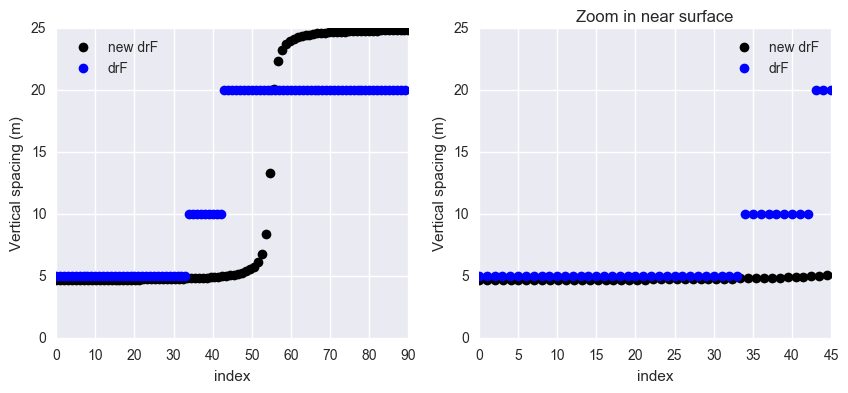

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(np.linspace(0,90,90),6.5*np.arctan(np.linspace(-70,45,90))+14.8, 'ko',label = 'new drF')
ax1.plot(range(90), drF,'bo',label = 'drF')
ax1.legend(loc=0)
ax1.set_xlabel('index')
ax1.set_ylabel('Vertical spacing (m)')

ax2.plot(np.linspace(0,90,90),6.5*np.arctan(np.linspace(-70,45,90))+14.8, 'ko',label = 'new drF')
ax2.plot(range(90), drF,'bo',label = 'drF')
ax2.legend(loc=0)
ax2.set_xlabel('index')
ax2.set_ylabel('Vertical spacing (m)')
ax2.set_xlim(0,45)
ax2.set_title('Zoom in near surface')

In [7]:
# Save new spacing
new_drF = 6.5*np.arctan(np.linspace(-71,40,91))+14.8
new_depths = np.empty(91)

for ii in range(91):
    new_depths[ii] = np.sum(new_drF[0:ii])

for ii in range(85,91):
    new_depths[ii] = np.sum(new_depths[ii-1]+(1200-new_depths[84])/6)
    new_drF[ii] = (1200-new_depths[84])/6

(-20, 1220)

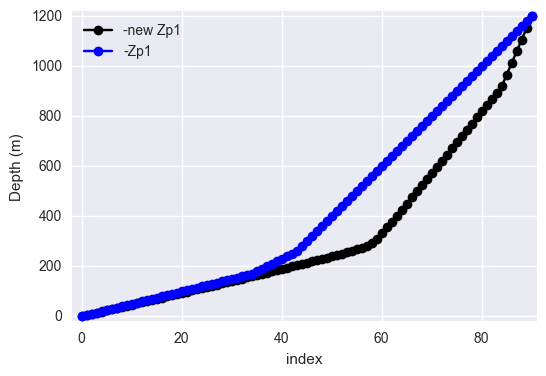

In [8]:
fig,ax1 = plt.subplots(1,1, figsize=(6,4))
ax1.plot(range(91),new_depths, 'ko-',label ='-new Zp1')
ax1.plot(range(91),-Zp1,'bo-',label='-Zp1')
ax1.legend(loc=0)
ax1.set_xlabel('index')
ax1.set_ylabel('Depth (m)')
ax1.set_xlim(-2,91)
ax1.set_ylim(-20,1220)


**Note that I changed the last depths (index 85 to 90) manually**

I get the new spacing as : $6.5*\arctan(np.linspace(-71,40,91))+14.8$

And the new depth as the sum of the spacing.

In [9]:
for dep in new_depths:
    print('%1.0f' %dep)

0
5
9
14
19
23
28
33
37
42
47
52
56
61
66
70
75
80
85
89
94
99
103
108
113
118
122
127
132
137
142
146
151
156
161
166
170
175
180
185
190
195
200
204
209
214
219
224
230
235
240
245
251
256
262
268
274
282
293
311
333
356
379
403
427
451
475
500
524
549
573
598
623
647
672
697
721
746
771
795
820
845
870
895
919
966
1013
1060
1106
1153
1200


In [16]:
zi = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,
      145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,
      260,265,270,275,280,290,300,311,333,356,379,403,427,451,475,500,524,549,573,598,623,
      647,672,697,721,746,771,795,820,845,870,895,919,966,1013,1060,1106,1153,1200]) # New depths

dz = zi[1:]-zi[:-1]

In [17]:
print(dz)

[ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5 10 10 11 22 23 23 24 24 24 24 25 24 25 24 25 25 24 25 25
 24 25 25 24 25 25 25 25 24 47 47 47 46 47 47]


In [18]:
print(np.sum(dz))
print(np.shape(dz))

1200
(90,)
